In [80]:
from data import digs_data_loader
from data import utils as du
from data import se3_diffuser
from data import so3_diffuser
from data import r3_diffuser_vpsde
from analysis import plotting
from analysis import utils as au
from collections import defaultdict
import numpy as np
from model import loss
from model import ipa_pytorch
from model import reverse_se3_diffusion
import tree
from experiments import train_se3_diffusion
from openfold.utils import rigid_utils as ru
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from matplotlib import animation
from mpl_toolkits import mplot3d
from scipy.spatial.transform import Rotation

Rigid = ru.Rigid

from omegaconf import OmegaConf
import importlib
import os
import torch
import tree
import copy

# Enable logging
import logging
import sys
date_strftime_format = "%Y-%m-%y %H:%M:%S"
logging.basicConfig(stream=sys.stdout, level=logging.INFO, format="%(asctime)s %(message)s", datefmt=date_strftime_format)

device = 'cuda' if torch.cuda.is_available() else 'cpu'


In [81]:
importlib.reload(digs_data_loader)
importlib.reload(se3_diffuser)
importlib.reload(so3_diffuser)
importlib.reload(du)
importlib.reload(ipa_pytorch)
importlib.reload(plotting)
importlib.reload(loss)
importlib.reload(au)
importlib.reload(train_se3_diffusion)
importlib.reload(r3_diffuser_vpsde)
importlib.reload(reverse_se3_diffusion)


<module 'model.reverse_se3_diffusion' from '/home/jyim/Projects/protein_diffusion_v2/model/reverse_se3_diffusion.py'>

In [138]:
base_conf_path = '../config/base.yaml'
base_conf = OmegaConf.load(base_conf_path)

# Load model checkpoint
ckpt_dir = '../pkl_jar/ckpt/sanity_check_no_crop_24D_08M_2022Y_10h_01m_05s'
# ckpt_dir = '../pkl_jar/ckpt/sanity_check_no_crop_24D_08M_2022Y_10h_01m_05s'
ckpt_dir = '../pkl_jar/ckpt/subset_100_24D_08M_2022Y_11h_30m_59s'
# ckpt_dir = '../pkl_jar/ckpt/subset_1000_24D_08M_2022Y_11h_31m_20s'


if len(os.listdir(ckpt_dir)) != 1:
    raise ValueError(f'Ambiguous ckpt in {ckpt_dir}')
ckpt_path = os.path.join(
    ckpt_dir, os.listdir(ckpt_dir)[0])
print(ckpt_path)
ckpt_pkl = du.read_pkl(ckpt_path)
ckpt_conf = ckpt_pkl['conf']
ckpt_model = ckpt_pkl['model']

conf = OmegaConf.merge(base_conf, ckpt_conf)

conf.experiment.data_location = 'digs'
conf.data.digs.cache_dir = '../pkl_jar/'
# conf.data.digs.crop_len = 50

# print(OmegaConf.to_yaml(ckpt_conf))

../pkl_jar/ckpt/subset_100_24D_08M_2022Y_11h_30m_59s/epoch_551.pkl


## Run inference

In [139]:
# Initialize model class
exp = train_se3_diffusion.Experiment(conf=conf)
exp.model.load_state_dict(ckpt_model)
exp.model.to(device)
exp_diffuser = exp.diffuser
train_loader, _, valid_loader, _ = exp.create_digs_dataset(0, 1)
exp_diffuser = exp.diffuser

INFO: Number of model parameters 3488030
INFO: Using R^3 VP-SDE
INFO: Loaded data at ../pkl_jar/dataset_5.0_260_60_80.0_100_2020-Apr-30_100.pkl
INFO: Loaded data at ../pkl_jar/dataset_5.0_260_60_80.0_100_2020-Apr-30_100.pkl


Using cached IGSO3.


In [140]:
# Sample data point to initializez.
data_iter = iter(train_loader)
raw_data_feats = next(data_iter)

/home/jyim/Projects/protein_diffusion_v2/data/digs_data_loader.py:283: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  'xyz': torch.tensor(centered_pos),


In [184]:
# Preprocess init data
batch_idx = 5
data_feats = tree.map_structure(lambda x: x[batch_idx], raw_data_feats)
res_mask = data_feats['res_mask']
res_idx = data_feats['res_idx']
rigids_0 = data_feats['rigids_0']

rigids_0 = rigids_0[torch.where(res_mask.bool())]
res_mask = res_mask[torch.where(res_mask.bool())]

num_res = res_mask.shape[0]
rigids_init = exp_diffuser.random_init(num_res).to_tensor_7()
rigids_init *= res_mask[:, None]
init_feats = {
    'rigids_t': rigids_init,
    'res_mask': res_mask,
    'res_idx': res_idx,
    'res_idx': res_idx[torch.where(res_mask.bool())],
    't': torch.tensor(exp_diffuser.num_t),
}

num_res = res_mask.shape[0]
init_feats = tree.map_structure(lambda x: x[None].to(device), init_feats)
print(f'Sample length {torch.sum(res_mask)}')

Sample length 138


In [185]:
# Run inference
infer_out = exp.inference_fn(init_feats, add_noise=True)
sample_rigids = infer_out[0]

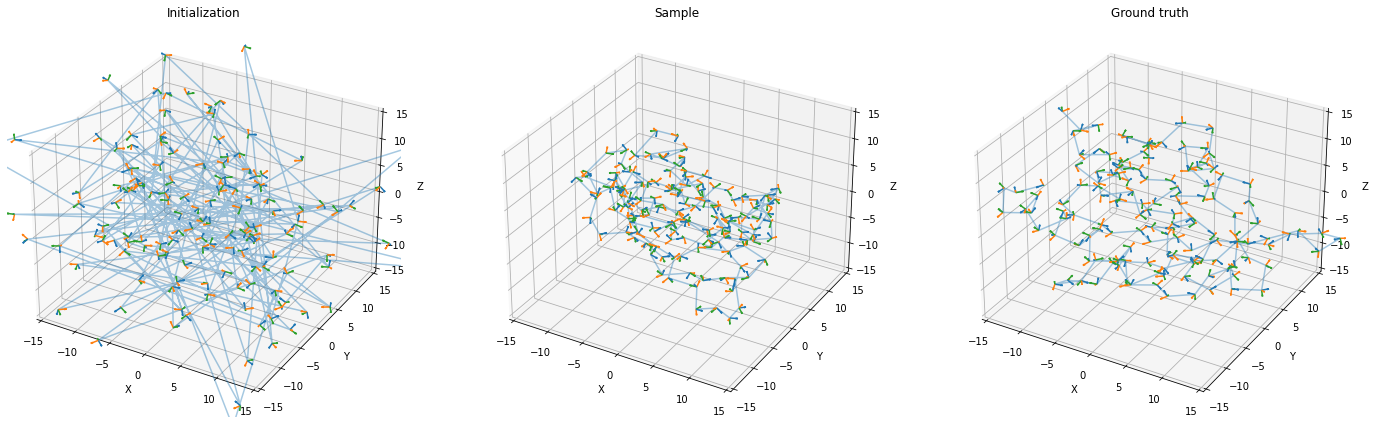

In [186]:
# Plot out SE(3)
final_rigid = sample_rigids[-1][0]
f, axes = plt.subplots(1, 3, figsize=[24, 8], subplot_kw=dict(projection="3d"))
scale_factor = conf.data.digs.scale_factor
ax_lim = 15.
plotting.viz_frames(init_feats['rigids_t'][0], res_mask, axes[0], title='Initialization', scale_factor=scale_factor, ax_lim=ax_lim)
plotting.viz_frames(final_rigid, res_mask, axes[1], title='Sample', scale_factor=scale_factor, ax_lim=ax_lim)
plotting.viz_frames(rigids_0, res_mask, axes[2], title='Ground truth', scale_factor=scale_factor, ax_lim=ax_lim)

In [170]:
# Calculate FAPE and Ca-RMSD metrics.
fape_loss = loss.rigids_fape(
    final_rigid,
    rigids_0.to(device),
    res_mask.to(device),
    length_scale=scale_factor)
rmsd_loss, aligned_pred_ca, gt_ca, align_rot_mat, align_trans, reflection = loss.rigids_ca_rmsd(
    final_rigid,
    rigids_0.to(device),
    res_mask.to(device),
    length_scale=scale_factor,
    return_align=True)
align_rot_euler = Rotation.from_matrix(align_rot_mat).as_euler('xyz', degrees=True)
print(f'FAPE: {fape_loss:2.4f}\nCa-RMSD: {rmsd_loss:2.4f}')
print(f'Alignment rotation: {align_rot_euler}\nAlignment translation: {align_trans[:,0]}\nAlignment reflection: {reflection}')


FAPE: 0.1125
Ca-RMSD: 1.4772
Alignment rotation: [-161.80970248  -28.02078012 -162.11370622]
Alignment translation: [ 3.1527287e-07 -7.3672815e-08  3.1333489e-08]
Alignment reflection: False


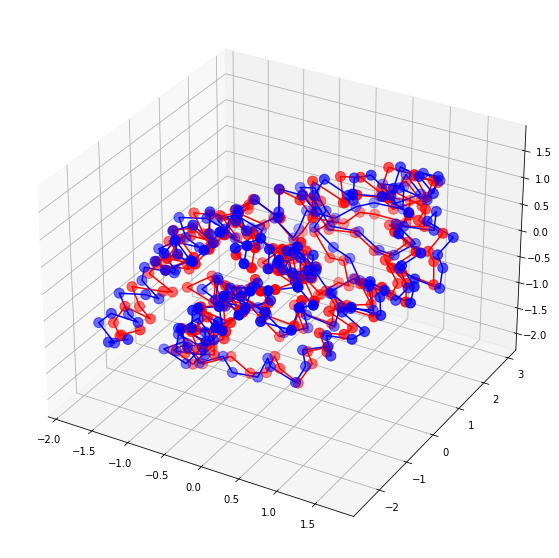

In [171]:
# Visualize aligned Ca structures
fig = plt.figure(figsize=(10, 10))
ax = plt.axes(projection='3d')

plotting.plt_3d(aligned_pred_ca, ax, color='r', s=100, mode='scatter')
plotting.plt_3d(aligned_pred_ca, ax, color='r', mode='line')
plotting.plt_3d(gt_ca, ax, color='b', s=100, mode='scatter')
plotting.plt_3d(gt_ca, ax, color='b', mode='line')

In [172]:
all_preds = [sample_rigids[0]]
reverse_steps = list(reversed(range(exp.diffuser.num_t)))
for t in reverse_steps:
    rigid_t = sample_rigids[exp.diffuser.num_t - 1 - t]
    feats_t = copy.deepcopy(init_feats)
    feats_t['rigids_t'] = rigid_t
    feats_t['t'] = (
        t * torch.ones_like(
            feats_t['t'],
            device=device)).to(device)
    with torch.no_grad():
        model_out = exp.model(feats_t)
    pred_t = exp.diffuser._r3_diffuser.one_shot_sample(
        feats_t['rigids_t'],
        model_out['trans_score'],
        feats_t['t'],
        feats_t['res_mask'])
    all_preds.append(pred_t)

Text(0.5, 0.92, 'Aligned with ground truth in training')

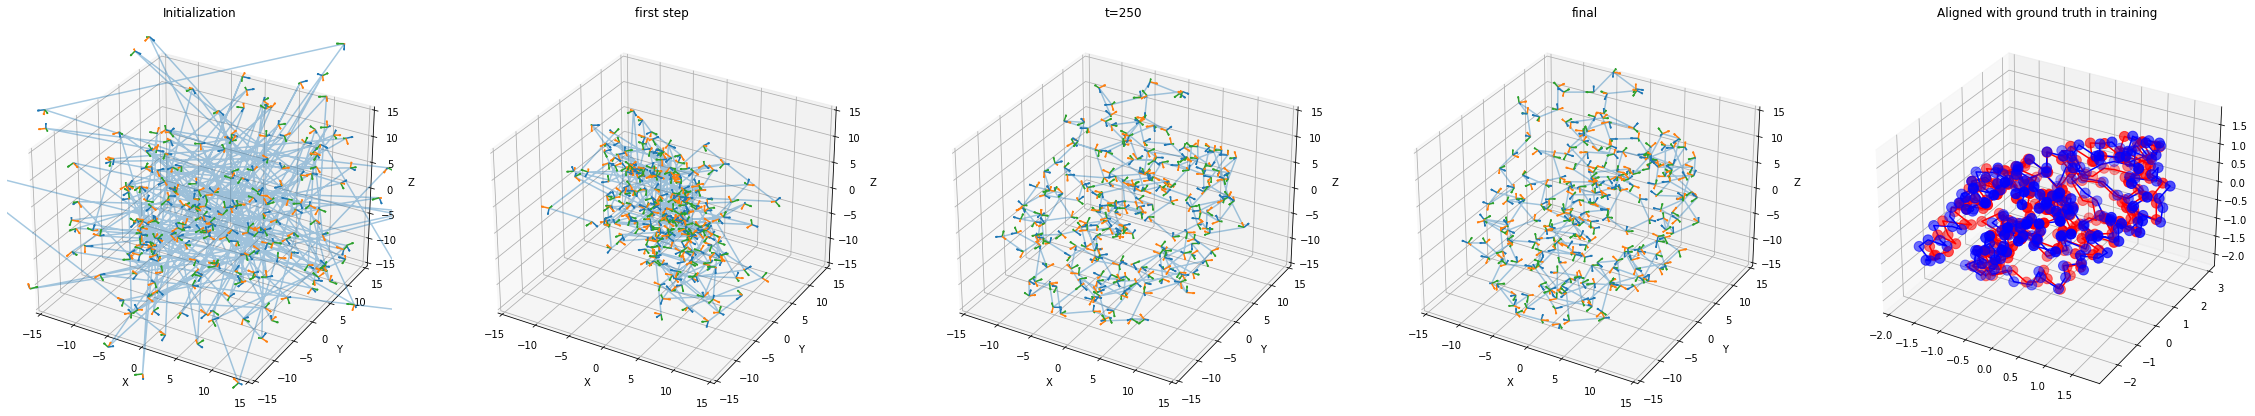

In [182]:
# final_rigid = all_preds[-1][0]
f, axes = plt.subplots(1, 5, figsize=[40, 8], subplot_kw=dict(projection="3d"))
scale_factor = conf.data.digs.scale_factor
ax_lim = 15.
plotting.viz_frames(all_preds[0][0], res_mask, axes[0], title='Initialization', scale_factor=scale_factor, ax_lim=ax_lim)
plotting.viz_frames(all_preds[1][0], res_mask, axes[1], title='first step', scale_factor=scale_factor, ax_lim=ax_lim)
# plotting.viz_frames(all_preds[100][0], res_mask, axes[2], title='t=400', scale_factor=scale_factor, ax_lim=ax_lim)
plotting.viz_frames(all_preds[250][0], res_mask, axes[2], title='t=250', scale_factor=scale_factor, ax_lim=ax_lim)
plotting.viz_frames(all_preds[-1][0], res_mask, axes[3], title='final', scale_factor=scale_factor, ax_lim=ax_lim)
# plotting.viz_frames(all_preds[-1][0], res_mask, axes[3], title='final', scale_factor=scale_factor, ax_lim=ax_lim)
# plotting.viz_frames(rigids_0, res_mask, axes[4], title='Ground truth', scale_factor=scale_factor, ax_lim=ax_lim)
# plotting.viz_frames(rigids_0, res_mask, axes[2], title='Ground truth', scale_factor=scale_factor, ax_lim=ax_lim)

plotting.plt_3d(aligned_pred_ca, axes[4], color='r', s=100, mode='scatter')
plotting.plt_3d(aligned_pred_ca, axes[4], color='r', mode='line')
plotting.plt_3d(gt_ca, axes[4], color='b', s=100, mode='scatter')
plotting.plt_3d(gt_ca, axes[4], color='b', mode='line')
axes[4].set_title('Aligned with ground truth in training')

INFO: Animation.save using <class 'matplotlib.animation.PillowWriter'>


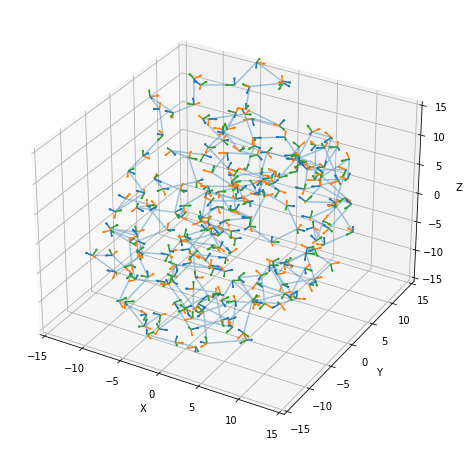

In [183]:
# Save trajectory as a gif
save_path = 'progressive_x0_2.gif'
sample_traj = torch.stack(all_preds)[:, 0]
ax_lim = 15
plotting.write_traj(
    sample_traj, res_mask, save_path, ax_lim=ax_lim, scale_factor=scale_factor
)

In [ ]:
# Run reverse process.
sample_feats = copy.deepcopy(data_init)
device = sample_feats['rigids_t'].device
reverse_steps = list(reversed(range(exp.diffuser.num_t)))
all_steps = [copy.deepcopy(sample_feats['rigids_t'])]
all_rot_scores = []
all_trans_scores = []
all_local_trans_scores = []
for t in reverse_steps[:-1]:
    sample_feats['t'] = (
        t * torch.ones_like(
            sample_feats['t'],
            device=device)).to(device)
    with torch.no_grad():
        model_out = self.model(sample_feats)
    rot_score = model_out['rot_score']
    trans_score = model_out['trans_score']
    local_trans_score = model_out['local_trans_score']
    sample_feats['rigids_t'] = self.diffuser.reverse_sample(
        sample_feats['rigids_t'],
        rot_score,
        trans_score,
        sample_feats['t'],
        torch.ones_like(sample_feats['res_mask']),
        add_noise=add_noise
    )
    all_steps.append(copy.deepcopy(sample_feats['rigids_t']))
    all_rot_scores.append(copy.deepcopy(rot_score))
    all_trans_scores.append(copy.deepcopy(trans_score))
    all_local_trans_scores.append(copy.deepcopy(local_trans_score))
return all_steps, all_rot_scores, all_trans_scores, all_local_trans_scores

In [17]:
# Run inference
infer_out = exp.inference_fn(init_feats, add_noise=True)
sample_rigids = infer_out[0]

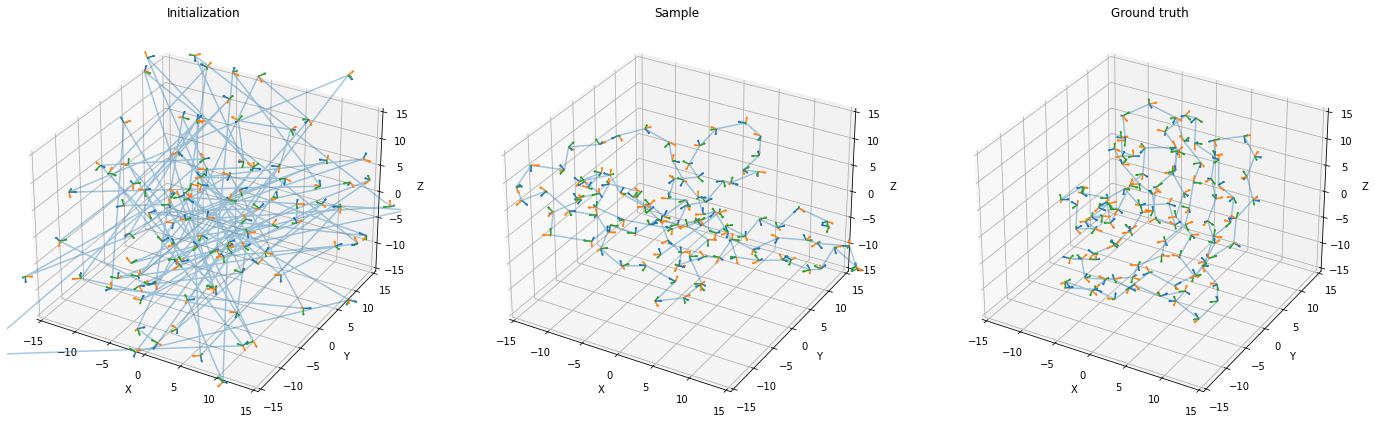

In [18]:
# Plot out SE(3)
final_rigid = sample_rigids[-1][0]
f, axes = plt.subplots(1, 3, figsize=[24, 8], subplot_kw=dict(projection="3d"))
scale_factor = conf.data.digs.scale_factor
ax_lim = 15.
plotting.viz_frames(init_feats['rigids_t'][0], res_mask, axes[0], title='Initialization', scale_factor=scale_factor, ax_lim=ax_lim)
plotting.viz_frames(final_rigid, res_mask, axes[1], title='Sample', scale_factor=scale_factor, ax_lim=ax_lim)
plotting.viz_frames(rigids_0, res_mask, axes[2], title='Ground truth', scale_factor=scale_factor, ax_lim=ax_lim)

In [ ]:
# Save final design as PDB.
ca_pos = final_rigid[:, 4:] * scale_factor
num_res = du.move_to_np(torch.sum(res_mask))
file_path = f'../samples/pdb/{os.path.basename(ckpt_dir)}/len_{num_res}_sample.pdb'
file_dir = os.path.dirname(file_path)
os.makedirs(file_dir, exist_ok=True)

save_path = au.write_prot_to_pdb(
    du.move_to_np(ca_pos),
    file_path
)
print(f'Written to {save_path}')

In [73]:
# Calculate FAPE and Ca-RMSD metrics.
fape_loss = loss.rigids_fape(
    final_rigid,
    rigids_0.to(device),
    res_mask.to(device),
    length_scale=scale_factor)
rmsd_loss, aligned_pred_ca, gt_ca, align_rot_mat, align_trans, reflection = loss.rigids_ca_rmsd(
    final_rigid,
    rigids_0.to(device),
    res_mask.to(device),
    length_scale=scale_factor,
    return_align=True)
align_rot_euler = Rotation.from_matrix(align_rot_mat).as_euler('xyz', degrees=True)
print(f'FAPE: {fape_loss:2.4f}\nCa-RMSD: {rmsd_loss:2.4f}')
print(f'Alignment rotation: {align_rot_euler}\nAlignment translation: {align_trans[:,0]}\nAlignment reflection: {reflection}')


det(R) < R, reflection detected!, correcting for it ...
FAPE: 0.1833
Ca-RMSD: 11.6174
Alignment rotation: [ 43.22644582 -15.51361478  83.08629319]
Alignment translation: [-2.6671428e-08  1.1060218e-08 -1.3305994e-07]
Alignment reflection: True


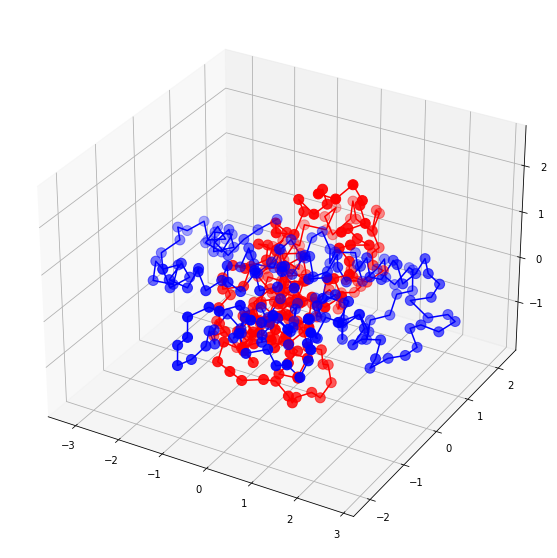

In [68]:
# Visualize aligned Ca structures
fig = plt.figure(figsize=(10, 10))
ax = plt.axes(projection='3d')

plotting.plt_3d(aligned_pred_ca, ax, color='r', s=100, mode='scatter')
plotting.plt_3d(aligned_pred_ca, ax, color='r', mode='line')
plotting.plt_3d(gt_ca, ax, color='b', s=100, mode='scatter')
plotting.plt_3d(gt_ca, ax, color='b', mode='line')

In [ ]:
# Save trajectory as a gif
save_path = 'dev_diffusion_4.gif'
sample_traj = torch.stack(sample_rigids)[:, 0]
ax_lim = 15
plotting.write_traj(
    sample_traj, res_mask, save_path, ax_lim=ax_lim, scale_factor=scale_factor
)